## Preparing the Dataset

In [50]:
# Download a labeled dataset for spam classification
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path ="sms_spam_collection.zip"
extrated_path = "sms_spam_collection"
data_file_path = Path(extrated_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
    url, zip_path, extrated_path, data_file_path):
    if data_file_path.exists():
        print(f"Data file already exists at {data_file_path}.")
        return
    with urllib.request.urlopen(url) as response:
        with open(zip_path, 'wb') as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extrated_path)
    
    original_file_path = Path(extrated_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"Data downloaded and extracted to {data_file_path}.")

download_and_unzip_spam_data(url, zip_path, extrated_path, data_file_path)

Data file already exists at sms_spam_collection/SMSSpamCollection.tsv.


In [51]:
# import dataset in pandas dataframe
import pandas as pd

df = pd.read_csv(data_file_path, sep='\t', header=None, names=['Label', 'Text'])
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [52]:
df.shape

(5572, 2)

In [53]:
df['Label'].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [54]:
# Handling class imbalance

def create_balanced_dataset(df):
    num_spam = df[df['Label'] == 'spam'].shape[0]
    ham_subset = df[df['Label'] == 'ham'].sample(n=num_spam, random_state=123)
    balanced_df = pd.concat([ham_subset, df[df['Label'] == 'spam']])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df['Label'].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [55]:
# Converting string class labels to integer class labels 0 and 1
label_mapping = {'ham': 0, 'spam': 1}
balanced_df['Label'] = balanced_df['Label'].map(label_mapping)
balanced_df.head()

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?


In [56]:
balanced_df['Label'].value_counts()

Label
0    747
1    747
Name: count, dtype: int64

In [57]:
# Splitting dataset into train (70%), validation(10%) and test(20%) set
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True) # Shuffle dataset
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)


In [58]:
# Saving the datasets
train_df.to_csv('train.csv', index=None)
validation_df.to_csv('validation.csv', index=None)
test_df.to_csv('test.csv', index=None)


In [59]:
train_df.head()

,Label,Text
0,0,Dude how do you like the buff wind.
1,0,Tessy..pls do me a favor. Pls convey my birthd...
2,1,Reminder: You have not downloaded the content ...
3,1,Got what it takes 2 take part in the WRC Rally...
4,1,"Shop till u Drop, IS IT YOU, either 10K, 5K, £..."


## Creating data loaders

In [60]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [61]:
# Setting up Pytorch Dataset class
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data['Text']]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def _longest_encoded_length(self):
        return max(len(encoded_text) for encoded_text in self.encoded_texts)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]['Label']
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

In [62]:
train_dataset = SpamDataset(csv_file='train.csv', tokenizer=tokenizer)

In [63]:
# Length of texts in training set should not exceed the context length of the model
train_dataset.max_length

120

In [64]:
# Pad validation and test datasets to match max_length of training dataset
val_dataset = SpamDataset(csv_file='validation.csv', tokenizer=tokenizer, max_length=train_dataset.max_length)
test_dataset = SpamDataset(csv_file='test.csv', tokenizer=tokenizer, max_length=train_dataset.max_length)

In [65]:
# Creating Pytorch data loaders

from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)


In [66]:
# Test dataloader by iterating over training loader and then print the tensor dimensions of the last batch

for input_batch, target_batch in train_dataloader:
    pass

print(f"Input batch shape: {input_batch.shape}, Target batch shape: {target_batch.shape}")

Input batch shape: torch.Size([8, 120]), Target batch shape: torch.Size([8])


In [67]:
# Print number of batches in each dataloader
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")

Number of training batches: 130
Number of validation batches: 19
Number of test batches: 38


## Initializing a model with pretrained weights

In [68]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {
        "emb_dim": 768,
        "n_layers": 12,
        "n_heads": 12
    },
    "gpt2-medium (355M)": {
        "emb_dim": 1024,
        "n_layers": 24,
        "n_heads": 16
    },
    "gpt2-large (774M)": {
        "emb_dim": 1280,
        "n_layers": 36,
        "n_heads": 20
    },
    "gpt2-xl (1558M)": {
        "emb_dim": 1600,
        "n_layers": 48,
        "n_heads": 25
    }
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [69]:
BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12}

In [70]:
# Loading a pretrained GPT model

from gpt_download import download_and_load_gpt2
from utils.gpt_model import GPTModel
from utils.weight_loader import load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

In [71]:
model_size

'124M'

In [72]:
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gtp2")

File already exists and is up-to-date: gtp2/124M/checkpoint
File already exists and is up-to-date: gtp2/124M/encoder.json
File already exists and is up-to-date: gtp2/124M/hparams.json
File already exists and is up-to-date: gtp2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gtp2/124M/model.ckpt.index
File already exists and is up-to-date: gtp2/124M/model.ckpt.meta
File already exists and is up-to-date: gtp2/124M/vocab.bpe


In [73]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features

In [74]:
from utils.text_generation import generate_text_simple, text_to_token_ids, token_ids_to_text
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [75]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially'"
    " 'selected to receive $1000 cash or $2000 award'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially' 'selected to receive $1000 cash or $2000 award' 'selected to receive $1000 cash or $2000 award' 'selected to receive $1000 cash or $2000 award


## Adding a Classification Head

In [76]:
# Foundation model
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features

In [77]:
# Freeze the foundation model i.e. make all layers non-trainable
for param in model.parameters():
    param.requires_grad = False


In [78]:
# Replace the output layer with a new classification layer
torch.manual_seed(123)
num_classes = 2  # Number of classes for spam classification
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

In [79]:
# Also make the final LayerNorm and last transformer block trainable
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [80]:
# Check models output after adding a new output layer
inputs = text_to_token_ids("Do you have time", tokenizer)
inputs

tensor([[5211,  345,  423,  640]])

In [81]:
inputs.shape

torch.Size([1, 4])

In [82]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


## Calculating the classification loss and accuracy

In [83]:
# Let's consider the last output token which has the information about all the tokens (Think about causal attention)
print("Last out token:", outputs[:, -1, :])

Last out token: tensor([[-3.5983,  3.9902]])


In [84]:
# Obtain the class label
probas = torch.softmax(outputs[:, -1, :], dim=-1) # Optional
label = torch.argmax(probas) # Index of maximum value in probas
print("Class label:", label.item())

Class label: 1


In [85]:
# Calculating the classification accuracy
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        with torch.no_grad():
            logits = model(input_batch)[:, -1, :]  # Logits of last output token
        predicted_labels = torch.argmax(logits, dim=-1)

        correct_predictions += (predicted_labels == target_batch).sum().item()
        num_examples += target_batch.size(0)

    accuracy = correct_predictions / num_examples if num_examples > 0 else 0.0
    return accuracy

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_dataloader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_dataloader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_dataloader, model, device, num_batches=10)

print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Train accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [87]:
# defining loss function to optimize during training (Fine tuning)

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


In [88]:
# Calculating the classification loss for all batches
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0

    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break

        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()

    return total_loss / num_batches if num_batches > 0 else float("nan")

In [89]:
# Calculate initial loss for all datasets
with torch.no_grad():
    train_loss = calc_loss_loader(train_dataloader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_dataloader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_dataloader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


## Fine-tuning the model on supervised data

In [90]:
# A simple method to fine-tune model to classify spam

def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculates loss gradients
            optimizer.step() # Updates model weights using loss gradients
            examples_seen += input_batch.shape[0]
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}"
                    )
            
        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")

        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


In [91]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # Set the model to evaluation mode. Dropout is disabled during evaluation for stable and reproducible results
    with torch.no_grad():  # Disable gradient calculation because we are not training the model here
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()  # Set the model back to training mode
    return train_loss, val_loss

In [92]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_dataloader, val_dataloader, optimizer, device, num_epochs, eval_freq=50, eval_iter=5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in: {execution_time_minutes:.2f} minutes")


Ep 1 (Step 000000): Train Loss: 2.153, Val Loss: 2.392
Ep 1 (Step 000050): Train Loss: 0.617, Val Loss: 0.637
Ep 1 (Step 000100): Train Loss: 0.523, Val Loss: 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train Loss: 0.561, Val Loss: 0.489
Ep 2 (Step 000200): Train Loss: 0.419, Val Loss: 0.397
Ep 2 (Step 000250): Train Loss: 0.409, Val Loss: 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train Loss: 0.333, Val Loss: 0.320
Ep 3 (Step 000350): Train Loss: 0.340, Val Loss: 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train Loss: 0.136, Val Loss: 0.200
Ep 4 (Step 000450): Train Loss: 0.153, Val Loss: 0.132
Ep 4 (Step 000500): Train Loss: 0.222, Val Loss: 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train Loss: 0.207, Val Loss: 0.143
Ep 5 (Step 000600): Train Loss: 0.083, Val Loss: 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Tra

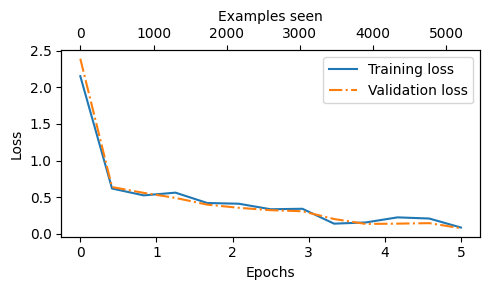

In [93]:
# Plotting the classification loss

import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, label=f"Validation {label}", linestyle='-.')

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

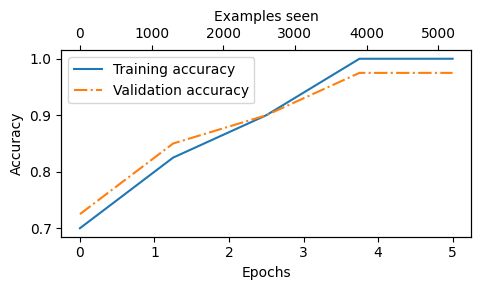

In [94]:
# Plot classification accuracy

epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [95]:
# Calculate accuracy on train, val and test sets with fine-tuned model

train_accuracy = calc_accuracy_loader(train_dataloader, model, device)
val_accuracy = calc_accuracy_loader(val_dataloader, model, device)
test_accuracy = calc_accuracy_loader(test_dataloader, model, device)

print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Train accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


In [96]:
# Save the fine-tuned model

torch.save(model.state_dict(), "fine_tuned_classifier_model.pth")

# Save along with optimizer
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "fine_tuned_classifier_model_and_optimizer.pth")


In [97]:
# Load model weights
finetuned_model = GPTModel(BASE_CONFIG)
finetuned_model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)
finetuned_model.load_state_dict(torch.load("fine_tuned_classifier_model.pth", map_location=device))

<All keys matched successfully>

## Using the LLM as a spam classifier

In [98]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    input_ids = input_ids[:min(max_length, supported_context_length)]

    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [99]:
text_1 = (
    "you are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award"
)

print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


In [103]:
text_2 = (
    "Congratsss ! you are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [106]:
print(classify_review(text_2, finetuned_model, tokenizer, device, max_length=train_dataset.max_length))

spam
